In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from IPython.display import display, Math
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

In [2]:
params = {'period@binary': 5.,
't0_supconj': 1.23,
'mass@primary': 3.2,
'mass@secondary': 0.93,
'requiv@primary': 2.5,
'requiv@secondary': 0.93,
'teff@primary': 10800,
'teff@secondary': 5610,
'incl@binary': 89.751,
'ecc': 0.32,
'per0': 86,
'pblum': 15.024,
'l3': 0.0}

In [3]:
np.random.seed(0)
times = np.random.uniform(0.0, 25, 500)
times.sort()

In [4]:
b = phoebe.default_binary(force_build=True)
b.add_dataset('lc', times = times)
b.flip_constraint('mass@secondary', solve_for='q')
b.flip_constraint('mass@primary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = (((({mass@primary@component} * ({period@binary@component} ** 2.000000)) * (1.000000 + {q@binary@component})) * 2942.206217504419328179210424423218) / 39.478418) ** (1./3) (solar units) => 5.299999999999999 solRad>

In [5]:
for twig in params.keys():
    b[twig] = params[twig]
b.run_delayed_constraints()
b.run_checks()

<RunChecksReport 3 items: status=WARNING>

In [6]:
b.add_compute('ellc', compute='ellcbnd')
b.set_value_all('ld_mode*', 'lookup')
b.run_compute(compute='ellcbnd')

100%|██████████| 1/1 [00:00<00:00, 27.95it/s]


<ParameterSet: 3 parameters | qualifiers: fluxes, comments, times>

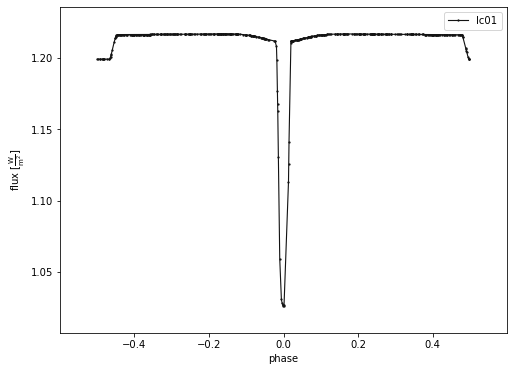

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [7]:
%matplotlib inline
b.plot(x='phase', s=0.01,  marker='.', legend=True, show=True)

In [8]:
times = b['value@times@model']
# add small gaussian noise to the fluxes
sigma = 0.001
np.random.seed(2)
fluxes = b['value@fluxes@model'] + np.random.normal(0,sigma,len(times))
sigmas = np.full_like(fluxes, sigma)
np.savetxt('data/d_ce.lc', np.array([times, fluxes, sigmas]).T)

In [9]:
b.save('data/d_ce.bundle')

'data/d_ce.bundle'

# OPTIMIZE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
from IPython.display import display, Math
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()

from optimize_funcs import *

## Nelder-Mead

In [2]:
label = 'd_ce'
b, b_true = setup_bundle(label)

In [3]:
ecc = 0.12
per0 = 1.3454511249399856
esinw = ecc*np.sin(per0)
ecosw = ecc*np.cos(per0)

100%|██████████| 1/1 [00:00<00:00, 20.19it/s]


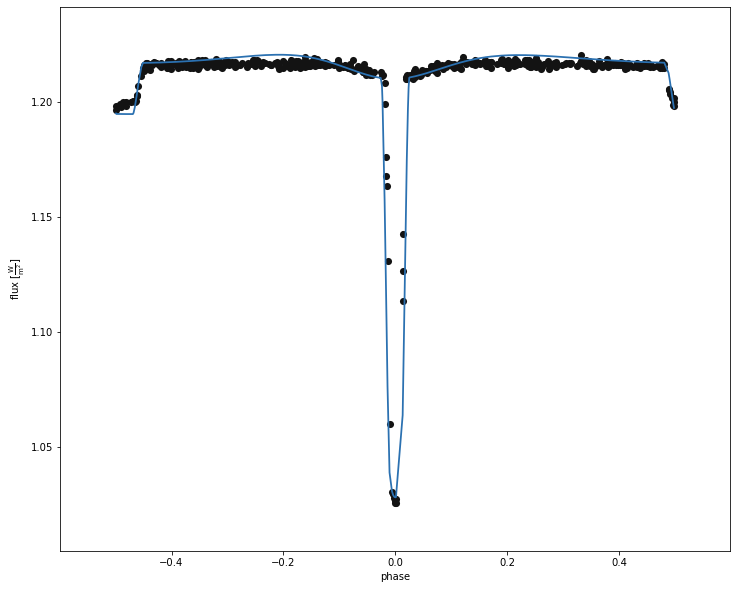

In [4]:
b = update_vals(b, 
                ['incl@binary', 'requivsumfrac', 'requivratio', 'teffratio', 'esinw', 'ecosw'], 
                [89., 0.18, 0.37, 0.55, 0.14, 0.025],
               'ellcbnd')

In [5]:
b.save('data/%s_manual.bundle' % label)

'data/d_ce_manual.bundle'

### optimize full

In [6]:
label = 'ce_nm'
b = phoebe.load('data/d_ce_manual.bundle')

65703it [07:39, 189.27it/s]                       
100%|██████████| 1/1 [00:00<00:00, 17.67it/s]


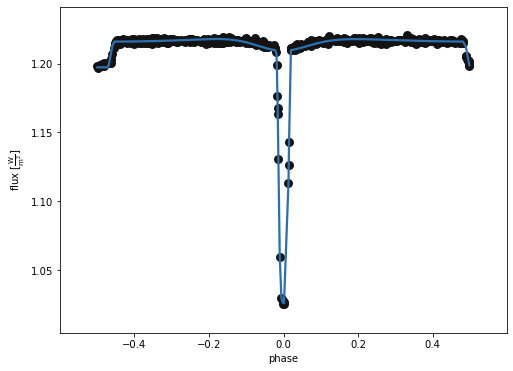

In [6]:
b=optimize_params(b, ['incl@binary', 'teffratio', 'requivratio', 'requivsumfrac', 'esinw', 'ecosw'], 'full', 'ellcbnd', optimizer='nm',  plot=True)

In [7]:
b.save('data/%s_full.bundle' % label)

'data/d_ce_full.bundle'

### sequential

In [8]:
b = phoebe.load('data/d_ce_manual.bundle')

In [9]:
%matplotlib qt
b.add_solver('estimator.lc_geometry', solver='est_lcgeom', phase_bin=False, fit_eclipses=True, interactive=False)
b.run_solver('est_lcgeom', solution='lcgeom_sol')

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


<ParameterSet: 22 parameters | qualifiers: primary_width, fitted_values, input_phases, secondary_width, input_fluxes, adopt_values, secondary_depth, fitted_twigs, analytic_fluxes, adopt_parameters, input_sigmas, adopt_distributions, secondary_phase, comments, fitted_uniqueids, eclipse_edges, analytic_best_model, primary_depth, orbit, primary_phase, fitted_units, analytic_phases>

In [10]:
b['mask_phases'] = b['value@fitted_values@lcgeom_sol'][-1]

In [11]:
%matplotlib inline


  1%|          | 10/1000 [00:05<18:04,  1.10s/it]
65703it [07:56, 189.27it/s]0:06<13:48,  1.19it/s]
  4%|▎         | 36/1000 [00:10<06:29,  2.48it/s]
65703it [08:01, 136.37it/s]0:11<05:09,  3.09it/s]

 99%|█████████▉| 990/1000 [00:54<00:00, 35.99it/s]
1035it [00:55, 36.19it/s]                         
1081it [00:56, 36.39it/s]
1128it [00:59, 28.60it/s]
1176it [01:00, 31.07it/s]
1225it [01:01, 33.31it/s]
1275it [01:04, 26.45it/s]
1326it [01:06, 28.84it/s]
1378it [01:07, 31.65it/s]
100%|██████████| 1/1 [00:00<00:00, 19.87it/s]


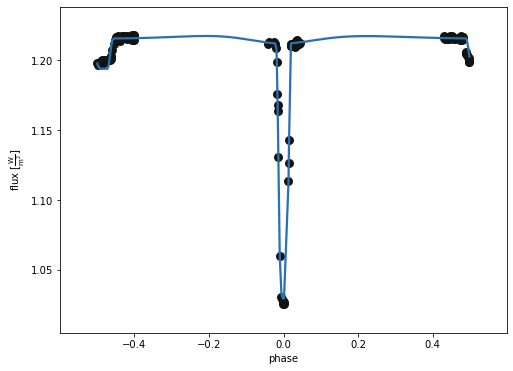

In [12]:
b = optimize_params(b, ['requivsumfrac','incl@binary'], 'rsumincl', 'ellcbnd',optimizer='nm', plot=True)

 12%|█▏        | 120/1000 [00:14<01:26, 10.19it/s]
1431it [01:34, 15.10it/s] [00:22<00:41, 18.20it/s]
100%|██████████| 1/1 [00:00<00:00, 18.09it/s]


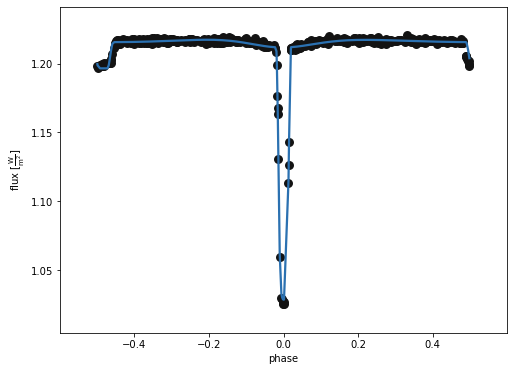

In [13]:
b['mask_phases'] = []
b = optimize_params(b, ['teffratio', 'esinw'], 'teffresw', 'ellcbnd', optimizer='nm', plot=True)


 41%|████      | 406/1000 [00:38<00:55, 10.68it/s][A

100%|██████████| 1/1 [00:00<00:00, 19.89it/s]it/s]


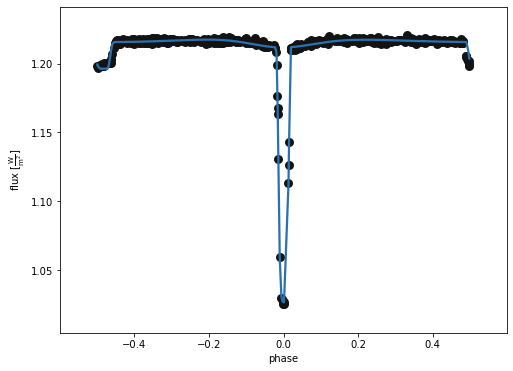

In [14]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio'], 'rsumrrteffr', 'ellcbnd', optimizer='nm', plot=True)

 78%|███████▊  | 780/1000 [00:48<00:13, 15.94it/s]
64980it [07:07, 225.84it/s]                       
100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


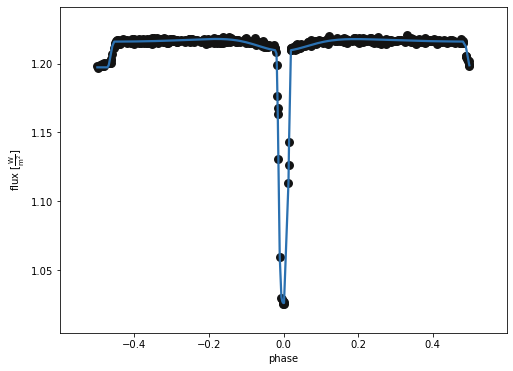

In [15]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 'all', 'ellcbnd', optimizer='nm', plot=True)

In [16]:
b.save('data/%s_seq.bundle' % label)

'data/d_ce_seq.bundle'

### grid search --> optimize

In [17]:
!scp angela@terra.villanova.edu:fitting/phoetting_paper/cases/AAS_poster/data/close_eccentric_manual_finegrid data/

close_eccentric_manual_finegrid               100% 4803KB  21.0MB/s   00:00    


In [18]:
gs_results = np.loadtxt('data/close_eccentric_manual_finegrid')
fit_params = ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw']
gs_results_filter = gs_results[gs_results[:,-1] != -np.inf]
minres = gs_results_filter[np.nanargmin(gs_results_filter[:,-1])]

In [19]:
b = phoebe.load('data/d_ce_manual.bundle')


100%|██████████| 1/1 [00:00<00:00, 19.43it/s]


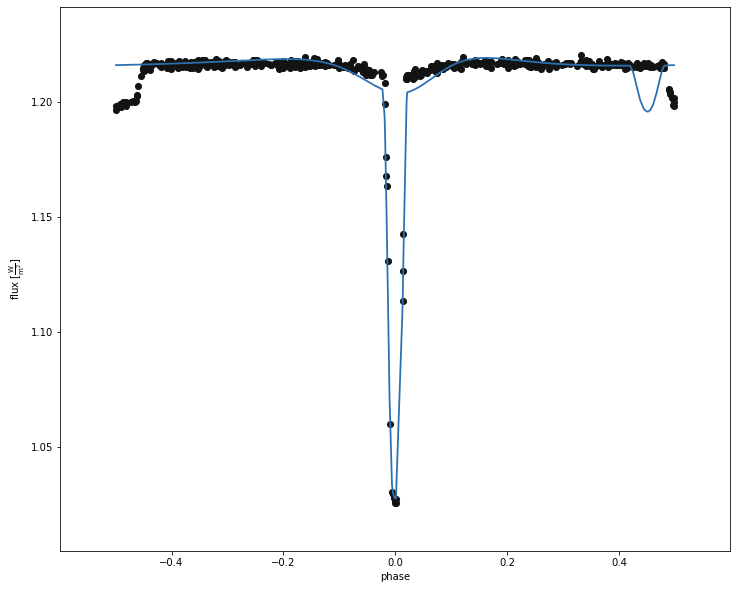

In [20]:
b = update_vals(b, 
                ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 
                minres[:-1],
               'ellcbnd')


  0%|          | 0/1000 [00:00<?, ?it/s]
64980it [07:19, 225.84it/s]:03<1:00:10,  3.61s/it]
  2%|▏         | 15/1000 [00:08<18:10,  1.11s/it]
64980it [07:25, 145.86it/s]0:09<13:51,  1.18it/s]

 99%|█████████▉| 990/1000 [00:53<00:00, 37.58it/s]
1035it [00:54, 34.25it/s]                         
1081it [00:55, 39.28it/s]
1128it [00:57, 35.90it/s]
1176it [00:57, 41.11it/s]
1225it [00:58, 46.14it/s]
1275it [00:59, 50.63it/s]
1326it [01:00, 46.24it/s]
1378it [01:01, 51.24it/s]
1431it [01:02, 55.61it/s]
1485it [01:03, 59.55it/s]
1540it [01:03, 62.91it/s]
1596it [01:05, 51.57it/s]
1653it [01:06, 48.64it/s]
1711it [01:07, 54.60it/s]
1770it [01:09, 48.18it/s]
1830it [01:09, 54.46it/s]
1891it [01:11, 49.07it/s]
1953it [01:12, 46.24it/s]
2016it [01:14, 46.56it/s]
2080it [01:14, 53.58it/s]
2145it [01:16, 51.92it/s]
2211it [01:17, 59.07it/s]
2278it [01:17, 65.45it/s]
2346it [01:19, 57.19it/s]
2415it [01:20, 63.78it/s]
2485it [01:21, 59.81it/s]
2556it [01:22, 55.11it/s]
2628it [01:23, 63.02it/s]
27

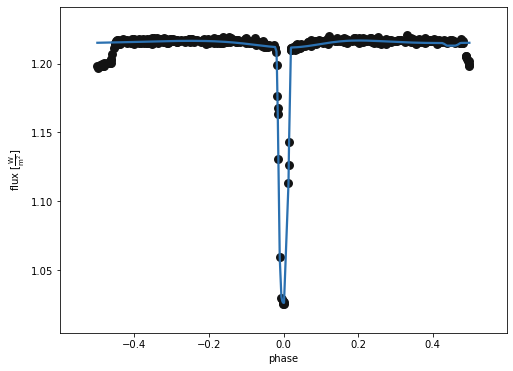

In [21]:
b = optimize_params(b, fit_params, 'after_gs', 'ellcbnd', optimizer='nm', plot=True)

In [22]:
b.save('data/%s_gs.bundle' % label)

'data/d_ce_gs.bundle'

## conjugate gradient

### optimize full

In [23]:
label = 'ce_cg'
b = phoebe.load('data/d_ce_manual.bundle')

  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
99235it [09:25, 175.46it/s]
  0%|          | 1/1000 [00:12<3:35:02, 12.92s/it]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
1378it [17:21,  2.61it/s]                          
100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


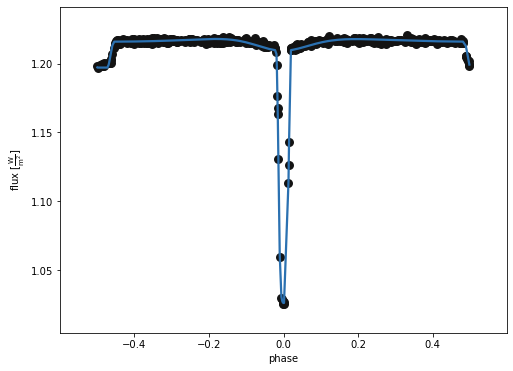

In [24]:
b=optimize_params(b, ['incl@binary', 'teffratio', 'requivratio', 'requivsumfrac', 'esinw', 'ecosw'], 'full', 'ellcbnd', optimizer='cg',  plot=True)

In [25]:
b.save('data/%s_full.bundle' % label)

'data/ce_cg_full.bundle'

### sequential

In [26]:
b = phoebe.load('data/d_ce_manual.bundle')

In [27]:
%matplotlib qt
b.add_solver('estimator.lc_geometry', solver='est_lcgeom', phase_bin=False, fit_eclipses=True, interactive=False)
b.run_solver('est_lcgeom', solution='lcgeom_sol')

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


<ParameterSet: 22 parameters | qualifiers: primary_width, fitted_values, input_phases, secondary_width, input_fluxes, adopt_values, secondary_depth, fitted_twigs, analytic_fluxes, adopt_parameters, input_sigmas, adopt_distributions, secondary_phase, comments, fitted_uniqueids, eclipse_edges, analytic_best_model, primary_depth, orbit, primary_phase, fitted_units, analytic_phases>

In [28]:
b['mask_phases'] = b['value@fitted_values@lcgeom_sol'][-1]

In [29]:
%matplotlib inline


1378it [18:26,  1.25it/s]00:00<?, ?it/s]
/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

  0%|          | 1/1000 [00:05<1:36:44,  5.81s/it]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

100%|██████████| 1/1 [00:00<00:00, 18.47it/s]s/it]


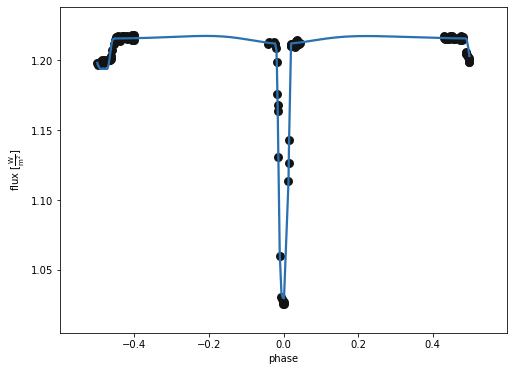

In [30]:
b = optimize_params(b, ['requivsumfrac','incl@binary'], 'rsumincl', 'ellcbnd',optimizer='cg', plot=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 3/1000 [01:54<10:35:17, 38.23s/it]

100%|██████████| 1/1 [00:00<00:00, 17.37it/s]


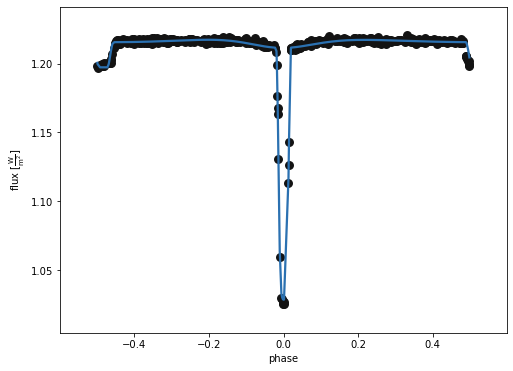

In [31]:
b['mask_phases'] = []
b = optimize_params(b, ['teffratio', 'esinw'], 'teffresw', 'ellcbnd', optimizer='cg', plot=True)


  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  0%|          | 1/1000 [01:01<17:03:20, 61.46s/it]

100%|██████████| 1/1 [00:00<00:00,  7.66it/s]it/s]


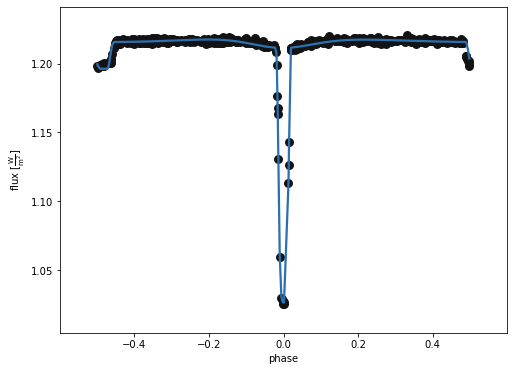

In [32]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio'], 'rsumrrteffr', 'ellcbnd', optimizer='cg', plot=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


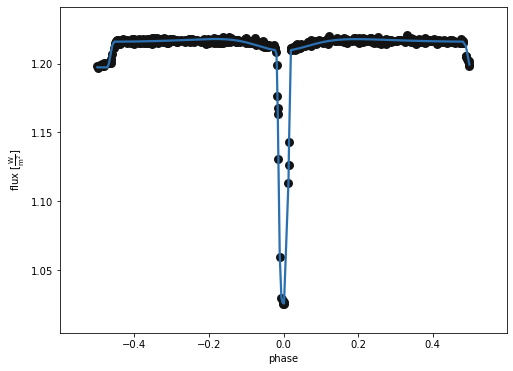

In [33]:
b = optimize_params(b, ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 'all', 'ellcbnd', optimizer='cg', plot=True)

In [34]:
b.save('data/%s_seq.bundle' % label)

'data/ce_cg_seq.bundle'

### grid search --> optimize

In [35]:
gs_results = np.loadtxt('data/close_eccentric_manual_finegrid')
fit_params = ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw']
gs_results_filter = gs_results[gs_results[:,-1] != -np.inf]
minres = gs_results_filter[np.nanargmin(gs_results_filter[:,-1])]

In [36]:
b = phoebe.load('data/d_ce_manual.bundle')


100%|██████████| 1/1 [00:00<00:00, 15.21it/s]


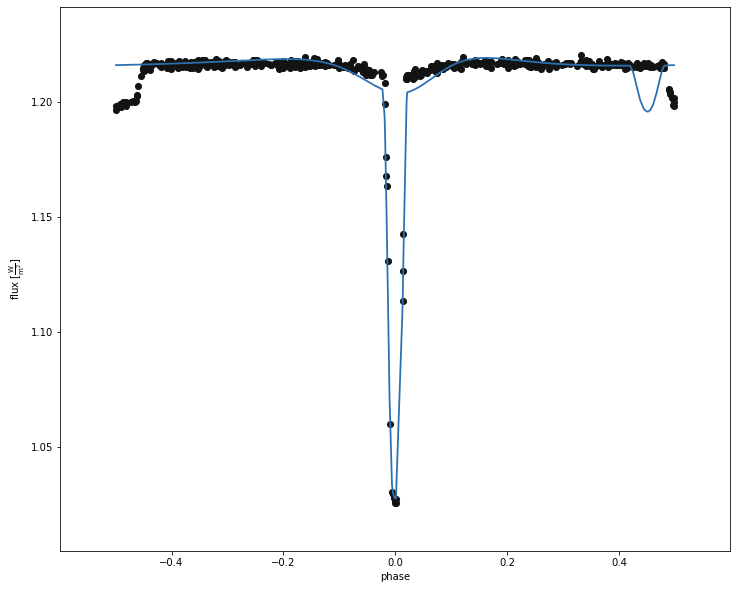

In [37]:
b = update_vals(b, 
                ['requivsumfrac', 'requivratio', 'teffratio', 'incl@binary', 'esinw', 'ecosw'], 
                minres[:-1],
               'ellcbnd')


  0%|          | 0/1000 [00:00<?, ?it/s]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
  7%|▋         | 66/1000 [06:39<1:34:14,  6.05s/it]

 15%|█▌        | 153/1000 [06:15<19:53,  1.41s/it]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0

 17%|█▋        | 171/1000 [07:58<37:20,  2.70s/it]/home/angela/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████| 1/1 [00:00<00:00, 15.91it/s]


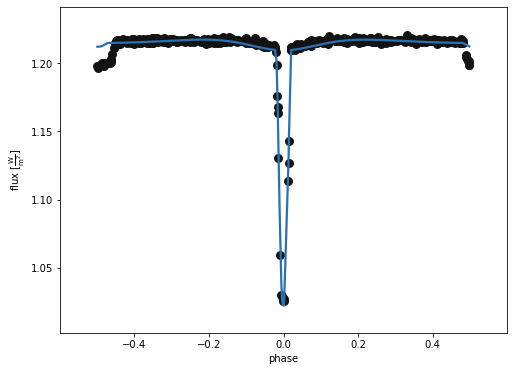

In [38]:
b = optimize_params(b, fit_params, 'after_gs', 'ellcbnd', optimizer='cg', plot=True)

In [39]:
b.save('data/%s_gs.bundle' % label)

'data/ce_cg_gs.bundle'

# MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe

from optimize_funcs import *

### initialize from good result

/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)
100%|██████████| 1/1 [00:00<00:00, 24.32it/s]


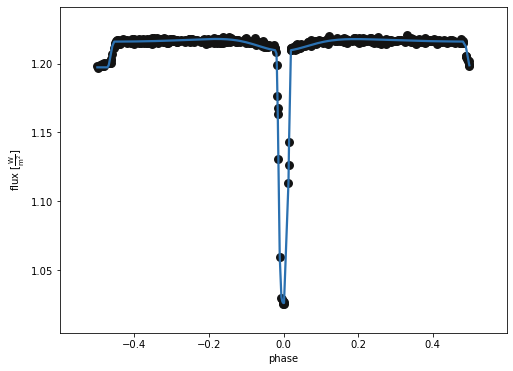

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [2]:
b = phoebe.load('data/ce_nm_seq.bundle')
b.run_compute(compute='ellcbnd', model='latest')
b.plot(['dataset', 'latest'], x='phase',show=True)

In [3]:
params0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'])
priors0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1]])

params_teff1_sma_q_p_t0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw', 
                                'teff@primary',
                                'sma@binary', 'q',
                                'period@binary', 't0_supconj'])
priors_teff1_sma_q_p_t0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1], 
                        [3500,20000],
                        [5,50], [0.1,10],
                        [np.nan,np.nan], [np.nan,np.nan]])

In [4]:
b=add_dist_solver_export(b, params0, priors0, 'ce_goodinit', '0')
b=add_dist_solver_export(b,params_teff1_sma_q_p_t0, priors_teff1_sma_q_p_t0, 'ce_goodinit', 'teff1_sma_q_p_t0')

In [5]:
b.save('data/ce_goodinit_dists.bundle')

'data/ce_goodinit_dists.bundle'

### initialize from bad result

100%|██████████| 1/1 [00:00<00:00, 24.91it/s]


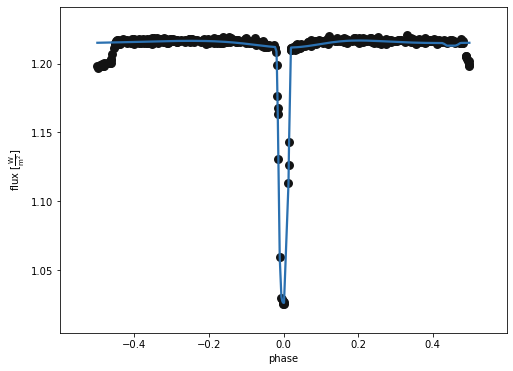

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [6]:
b = phoebe.load('data/ce_nm_gs.bundle')
b.run_compute(compute='ellcbnd', model='latest')
b.plot(['dataset', 'latest'], x='phase',show=True)

In [7]:
params0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw'])
priors0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1]])

params_teff1_sma_q_p_t0 = np.array(['incl@binary', 'teffratio', 'requivsumfrac', 'requivratio', 'esinw', 'ecosw', 
                                'teff@primary',
                                'sma@binary', 'q',
                                'period@binary', 't0_supconj'])
priors_teff1_sma_q_p_t0 = np.array([[50,90], [0.01,10], [0.0001, 1.], [0.1,10], [-1,1], [-1,1], 
                        [3500,20000],
                        [5,50], [0.1,10],
                        [np.nan,np.nan], [np.nan,np.nan]])

In [8]:
b=add_dist_solver_export(b,params0, priors0, 'ce_badinit', '0')
b=add_dist_solver_export(b,params_teff1_sma_q_p_t0, priors_teff1_sma_q_p_t0, 'ce_badinit', 'teff1_sma_q_p_t0')

In [9]:
b.save('data/ce_badinit_dists.bundle')

'data/ce_badinit_dists.bundle'

In [10]:
!scp angela@terra.villanova.edu:fitting/phoetting_paper/AAS_ellcbnd/ce_goodinit_0.py.out.progress .

ce_goodinit_0.py.out.progress                 100%  139MB  48.2MB/s   00:02    


/home/angela/anaconda3/lib/python3.7/site-packages/phoebe/parameters/parameters.py:9953: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


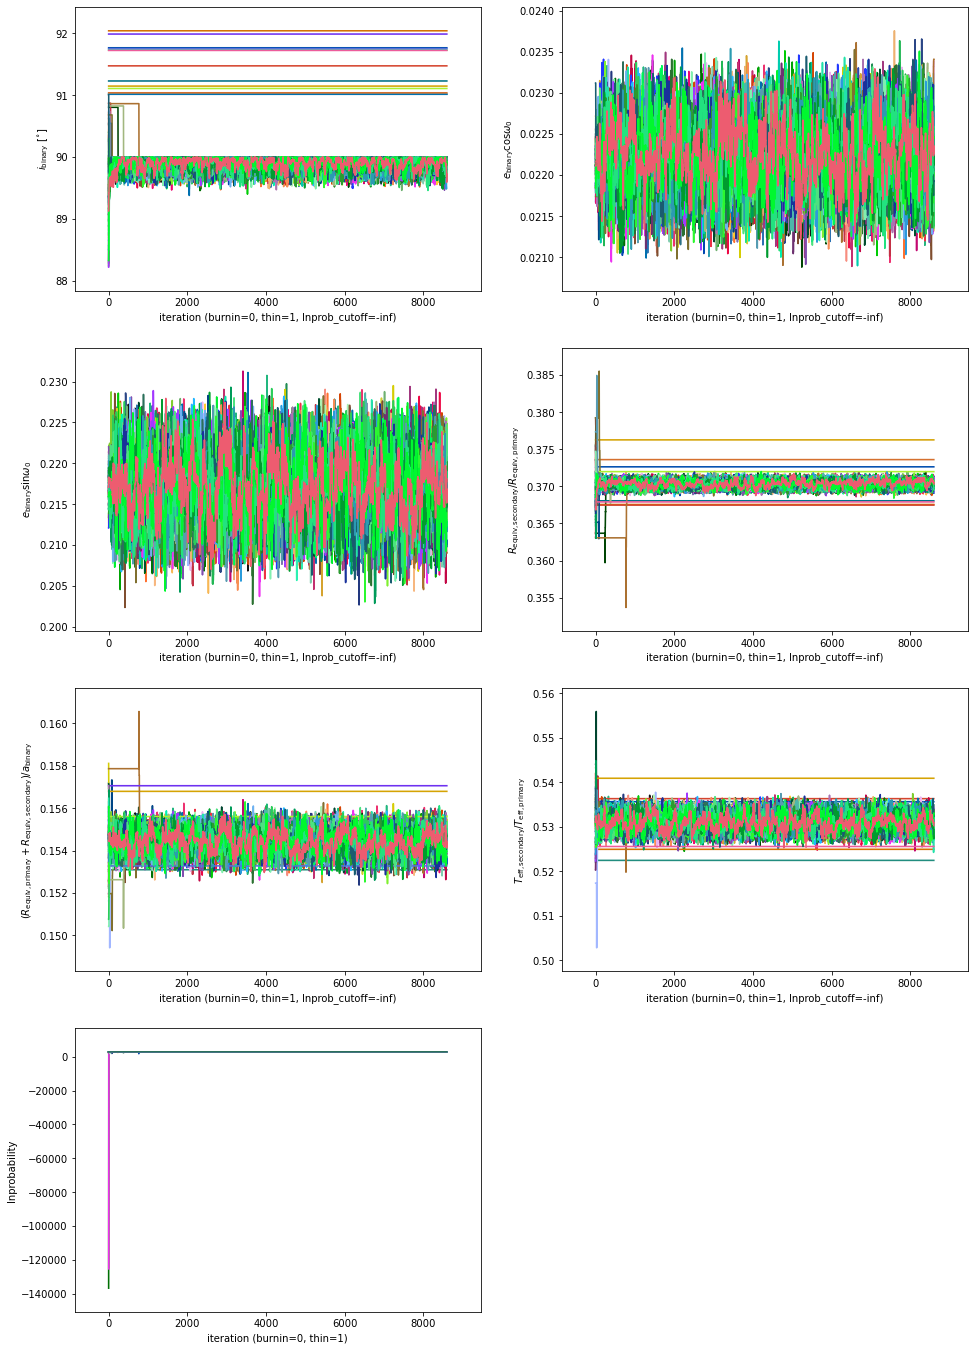

In [11]:
b = phoebe.load('data/ce_goodinit_dists.bundle', import_from_newer=True)
b.import_solution(r'ce_goodinit_0.py.out.progress', solution='lc_progress')
%matplotlib inline
afig, mplfig = b.plot(solution='lc_progress', burnin=0, thin=1, lnprob_cutoff = -np.inf, s=0.005, show=True)